In [17]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV

FigureCanvasNbAgg()

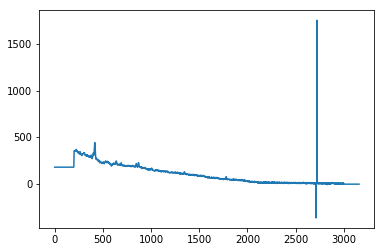

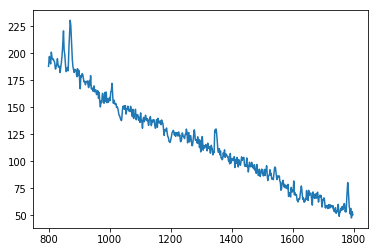

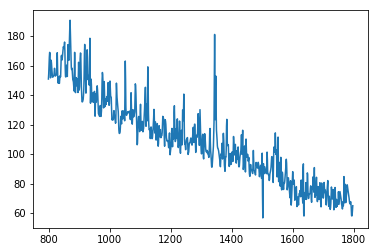

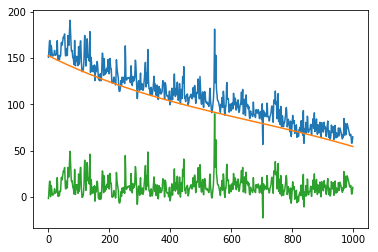

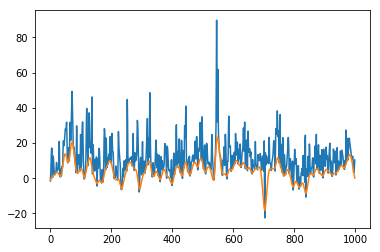

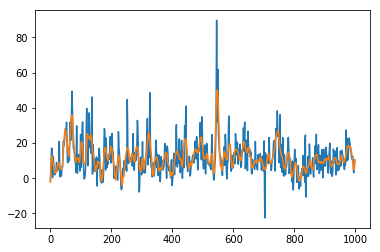

In [18]:
%run Preprocessing.ipynb

### XGBoost

In [19]:
xgbc = XGBClassifier()
xgbc.fit(X_train, y_train);

### Качество моделей (оценка на основе отложенной выборки)

In [20]:
pred_holdout_xgbc = xgbc.predict(X_holdout)
XGB_accuracy = accuracy_score(y_holdout, pred_holdout_xgbc)
XGB_accuracy

0.8333333333333334

### Кросс-валидация

In [41]:
#StratifiedKfold returns stratified folds, 
#i.e while making the folds it maintains the percentage of samples for each class in every fold. 

skf = StratifiedKFold(n_splits = 5, random_state=1, shuffle = True)

In [43]:
xgb_cvs = cross_val_score(xgbc, X_train, y_train, scoring='accuracy', cv = skf)
xgb_cvs

array([0.75, 0.5 , 1.  , 0.  , 0.5 ])

In [44]:
xgb_cvs.mean()

0.55

In [24]:
cv_params = {'max_depth': [3,5,7], 'min_child_weight': [1,3,5]}

In [25]:
ind_params = {'learning_rate': 0.1, 'n_estimators': 1000, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic'}

In [26]:
optimized_GBM = GridSearchCV(XGBClassifier(**ind_params), cv_params, scoring = 'accuracy', cv = 5, n_jobs = -1) 

In [27]:
optimized_GBM.fit(X_train, y_train)

/home/andrey/Projects/Kaggle-Raman-ML/env/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=True,
       subsample=0.8),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [3, 5, 7], 'min_child_weight': [1, 3, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [28]:
print(optimized_GBM.best_params_)
print(optimized_GBM.best_score_)

{'max_depth': 3, 'min_child_weight': 3}
0.5


In [29]:
cv_params = {'learning_rate': [0.1, 0.01], 'subsample': [0.7,0.8,0.9]}
ind_params = {'n_estimators': 1000, 'seed':0, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic', 'max_depth': 3, 'min_child_weight': 1}


optimized_GBM = GridSearchCV(XGBClassifier(**ind_params), 
                            cv_params, 
                             scoring = 'accuracy', cv = 5, n_jobs = -1)
optimized_GBM.fit(X_train, y_train)

/home/andrey/Projects/Kaggle-Raman-ML/env/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=True,
       subsample=1),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'learning_rate': [0.1, 0.01], 'subsample': [0.7, 0.8, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [30]:
print(optimized_GBM.best_params_)
print(optimized_GBM.best_score_)

{'learning_rate': 0.01, 'subsample': 0.7}
0.5714285714285714


In [31]:
xgbc_opt = XGBClassifier(max_depth=3, min_child_weight=1, learning_rate=0.1, subsample=0.7)
xgbc_opt.fit(X_train, y_train);

In [32]:
pred_holdout_xgbc_opt = xgbc_opt.predict(X_holdout)
accuracy_score(y_holdout, pred_holdout_xgbc)

0.8333333333333334